# BREWING DATA CUP - Reto Perú

Priorización de descuentos

## LIBRERIAS

In [ ]:
!pip install optuna

     |████████████████████████████████| 266kB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 11.4MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 133kB 12.7MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 112kB 17.0MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=a242335ef6293a14a9d372f1f90b3292087da4b7aae823dd4c2145e7def074a7
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=eb2e4aa49b30f16817426b0006c4a973c64a0ffb37853798ebd7bec8c75a1fef
  Stored in directory: /root/.cache/pip/whe

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
import lightgbm as lgb
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Optimizer
import optuna
# Others
import random
# Progress in console
from tqdm import tqdm
# Gargabe collector
import gc

## DATA

In [ ]:
!git clone https://github.com/brewing-datacup/reto-peru-2020

Cloning into 'reto-peru-2020'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
!7z e reto-peru-2020/data/peru-data.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 12312061 bytes (12 MiB)

Extracting archive: reto-peru-2020/data/peru-data.7z
--
Path = reto-peru-2020/data/peru-data.7z
Type = 7z
Physical Size = 12312061
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     17% 1 - clients_attributes.csv                                39% 3 - sales.csv                   57% 3 - sales.csv                   74% 3 - sales.csv                   93% 3 - sales.csv                  Everything is Ok

Files: 4
Size:       95395570
Compressed: 12312061


In [ ]:
active_promos = pd.read_csv('active_promos.csv')
executed_promos = pd.read_csv('executed_promos.csv')
sales = pd.read_csv('sales.csv', encoding = "ISO-8859-1")
clients_attributes = pd.read_csv('clients_attributes.csv')
test_example = pd.read_csv('reto-peru-2020/data/test.csv')

In [ ]:
active_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422437 entries, 0 to 422436
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   CodigoDC     422437 non-null  int64 
 1   Marca        422437 non-null  int64 
 2   Cupo         422437 non-null  int64 
 3   Fecha_Desde  422437 non-null  object
 4   Fecha_Hasta  422437 non-null  object
 5   Cliente      422437 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 19.3+ MB


In [ ]:
active_promos.head(3)

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente
0,297601,29,9,2018-08-06,2018-08-30,3213
1,297601,29,9,2018-08-06,2018-08-30,3795
2,297601,29,9,2018-08-06,2018-08-30,11816


In [ ]:
print(active_promos["CodigoDC"].unique().shape)

(26882,)


In [ ]:
executed_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27794 entries, 0 to 27793
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CodigoDC  27794 non-null  int64
 1   Cliente   27794 non-null  int64
 2   Marca     27794 non-null  int64
 3   Cupo      27794 non-null  int64
dtypes: int64(4)
memory usage: 868.7 KB


In [ ]:
executed_promos.tail()

,CodigoDC,Cliente,Marca,Cupo
27789,651436,9798,39,20
27790,651588,2397,39,20
27791,651597,4430,40,16
27792,651617,7347,39,20
27793,652143,1584,40,16


In [ ]:
executed_promos.loc[(executed_promos['Cliente'] == 9798) & (executed_promos['Marca'] == 39) & (executed_promos['Cupo'] == 20) ]

,CodigoDC,Cliente,Marca,Cupo
523,357701,9798,39,20
3823,604104,9798,39,20
21732,597220,9798,39,20
27789,651436,9798,39,20


In [ ]:
print(executed_promos["CodigoDC"].unique().shape)

(8838,)


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894252 entries, 0 to 1894251
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Cliente         int64  
 1   Año             int64  
 2   Mes             int64  
 3   ClaseEnvase     int64  
 4   SegmentoPrecio  float64
 5   Marca           int64  
 6   Cupo            float64
 7   Nr              float64
 8   Hl              float64
 9   Dcto            float64
dtypes: float64(5), int64(5)
memory usage: 144.5 MB


In [ ]:
sales.head(3)

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0


In [ ]:
sales["Año"].value_counts()

2018    1211185
2019     683067
Name: Año, dtype: int64

In [ ]:
sales["Marca"].unique().shape[0]

50

In [ ]:
sales[sales['Cliente']==15069]

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
1324809,15069,2019,3,1,2.0,44,30.0,4464.51,0.03,0.00
1324810,15069,2019,4,1,2.0,45,32.0,5041.38,0.02,0.00
1324811,15069,2019,6,1,2.0,44,32.0,24552.29,0.07,-632.77
1324812,15069,2019,6,2,2.0,44,16.0,8397.29,0.03,-937.82
1324813,15069,2019,7,1,2.0,44,32.0,12590.92,0.04,0.00
1326042,15069,2019,4,1,2.0,44,29.0,7729.12,0.04,-323.70
1326043,15069,2019,6,1,2.0,44,29.0,24153.50,0.13,0.00
1326044,15069,2019,6,1,2.0,44,30.0,17858.03,0.11,0.00
1326045,15069,2019,8,1,2.0,44,29.0,8051.17,0.04,0.00
1328083,15069,2019,5,1,2.0,44,30.0,8929.01,0.05,0.00


In [ ]:
print("Ventas por el cliente 15069 = {}".format(sales[sales['Cliente']==15069].shape[0]))
print("Ventas por el cliente 15068 = {}".format(sales[sales['Cliente']==15068].shape[0]))

Ventas por el cliente 15069 = 22
Ventas por el cliente 15068 = 54


In [ ]:
clients_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15069 entries, 0 to 15068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Cliente           15069 non-null  int64 
 1   FechaAltaCliente  15069 non-null  object
 2   Region            15069 non-null  int64 
 3   Gerencia          15069 non-null  int64 
 4   SubCanal          15069 non-null  int64 
 5   TipoPoblacion     15069 non-null  int64 
 6   Estrato           15069 non-null  int64 
 7   EF                15069 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 941.9+ KB


In [ ]:
clients_attributes.tail()

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
15064,15040,2019-03-07,1,16,9,2,1,0
15065,15043,2019-03-07,1,20,15,2,2,1
15066,15052,2019-03-09,3,7,10,2,2,0
15067,15065,2019-03-16,4,21,9,2,2,0
15068,15069,2019-03-18,4,14,9,2,1,0


In [ ]:
test_example.head(3)

,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,NaN
1,17,29,9,NaN
2,37,29,9,NaN


In [ ]:
test_example.shape

(16870, 4)

In [ ]:
active_promos.iloc[test_example['Cliente']].iloc[test_example['Marca']].iloc[test_example['Cupo']]

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente
302,354320,40,16,2018-08-29,2018-08-30,8206
299,354320,40,16,2018-08-29,2018-08-30,8097
299,354320,40,16,2018-08-29,2018-08-30,8097
299,354320,40,16,2018-08-29,2018-08-30,8097
299,354320,40,16,2018-08-29,2018-08-30,8097
...,...,...,...,...,...,...
302,354320,40,16,2018-08-29,2018-08-30,8206
302,354320,40,16,2018-08-29,2018-08-30,8206
302,354320,40,16,2018-08-29,2018-08-30,8206
299,354320,40,16,2018-08-29,2018-08-30,8097


Datos del test salen de active_promos, por lo que se deje trabajar con este

Existen tres datos del test que son declarados como ejecutados

## DATA MANIPULATION

Strategy: Join all data into Active Promos dataset

In [ ]:
active_promos.shape

(422437, 6)

In [ ]:
active_promos.head(3)

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente
0,297601,29,9,2018-08-06,2018-08-30,3213
1,297601,29,9,2018-08-06,2018-08-30,3795
2,297601,29,9,2018-08-06,2018-08-30,11816


In [ ]:
sales.head(3)

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0


In [ ]:
sales.shape

(1894252, 10)

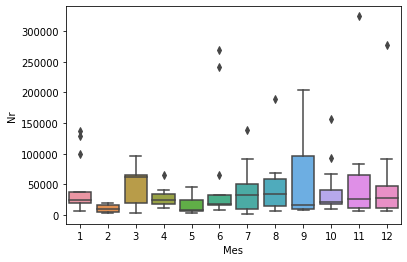

In [ ]:
temp = sales.loc[sales['Año']==2018].loc[sales['Cliente']==1]
sns.boxplot(temp['Mes'], temp['Nr'])

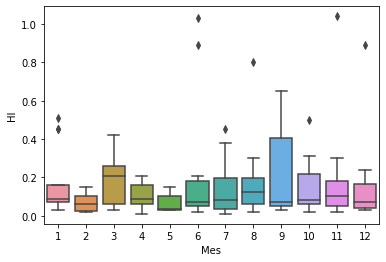

In [ ]:
temp = sales.loc[sales['Año']==2018].loc[sales['Cliente']==1]
sns.boxplot(temp['Mes'], temp['Hl'])

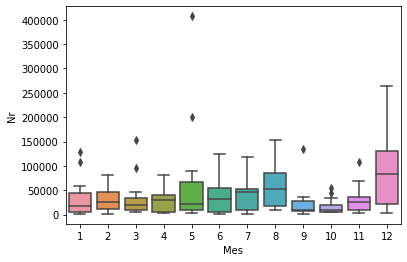

In [ ]:
temp = sales.loc[sales['Año']==2018].loc[sales['Cliente']==8206]
sns.boxplot(temp['Mes'], temp['Nr'])

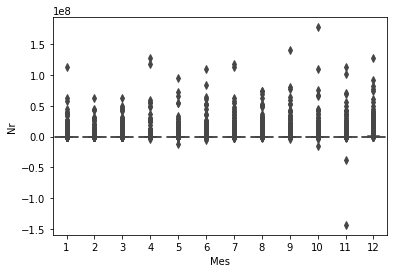

In [ ]:
temp = sales.loc[sales['Año']==2018]
sns.boxplot(temp['Mes'], temp['Nr'])

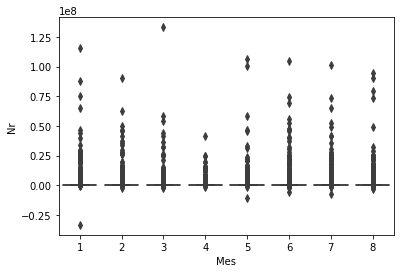

In [ ]:
temp = sales.loc[sales['Año']==2019]
sns.boxplot(temp['Mes'], temp['Nr'])

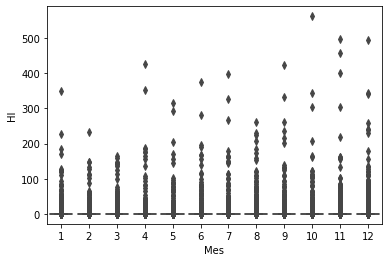

In [ ]:
temp = sales.loc[sales['Año']==2018]
sns.boxplot(temp['Mes'], temp['Hl'])

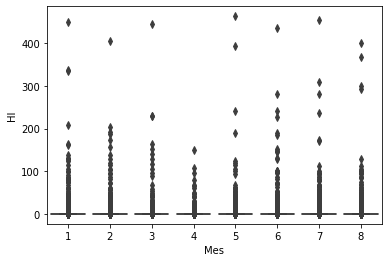

In [ ]:
temp = sales.loc[sales['Año']==2019]
sns.boxplot(temp['Mes'], temp['Hl'])

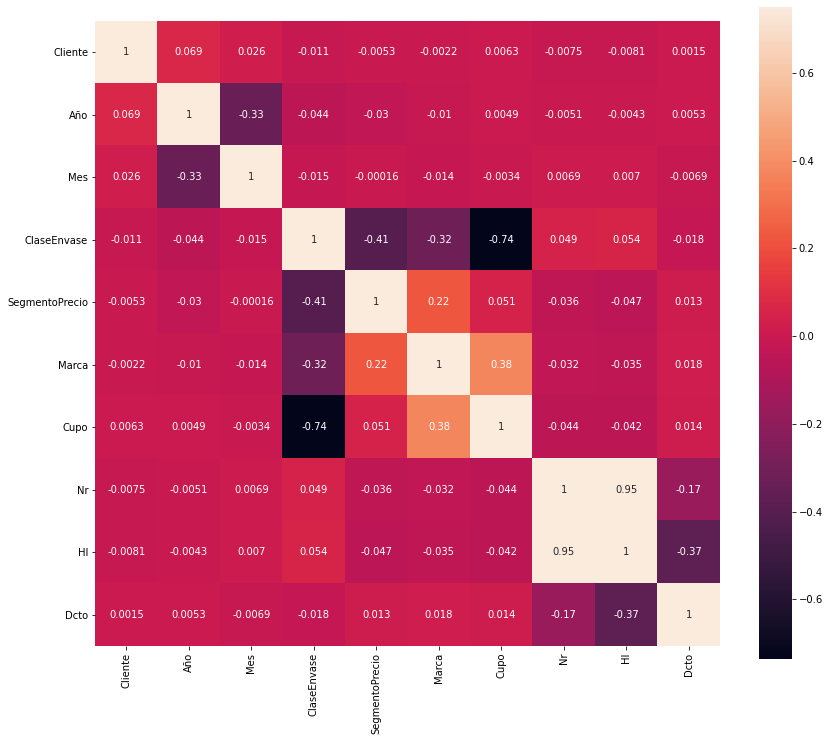

In [ ]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(sales.corr(), vmax = 0.75, square = True, annot = True)

Alta relación:

*   Cupo - Clase Envase (-0.74)
*   Hl - Nr (0.95)
*   Segmento Precio - Clase Envase (-0.41)

Diccionario

1.   Cupo: Cupo del producto ( tamaño o presentacion)
2.   Clase Envase: Envase de la marca cupo ( Retornable, No retornable, Solido)
3.   Hl: Volumen (hectolitros)
4.   Nr: Net Revenue
5.   Segmento Precio: Segmento Precio de la marca cupo (No cervecero, Mainstream, Premium, Super Premium)



**HYPOTESIS:**

Cliente - Marca - Cupo - Promo Ejecutada.

Active Promos:

1. CodigoDC, Cliente, Marca, Cupo, Desde, Hasta.

    *   Cliente: Filtro de Desde, Hasta en Sales y Generar Total de Ingresos. [Nr, Hl, Dcto].

    *   Marca - Cupo: Filtro de Desde, Hasta en Sales y Generar Total de Ventas. [Nr, Hl, Dcto]. 

    *   Añadir por Marca - Cupo: [Clase Envase, Segmento Precio].

    *   Añadir por cliente: Propiedades de 



In [ ]:
df1 = active_promos

In [ ]:
df1['Año'] = df1.apply (lambda a: a['Fecha_Desde'][0:4], axis=1)
df1['Mes'] = df1.apply (lambda a: a['Fecha_Desde'][5:7], axis=1)
df1=df1.astype({"Año": int, "Mes": int})

In [ ]:
df1['Fecha_Desde'] = pd.to_datetime(df1['Fecha_Desde'])
df1['Fecha_Hasta'] = pd.to_datetime(df1['Fecha_Hasta'])
df1['Promo_duration_days']=(df1['Fecha_Hasta'] - df1['Fecha_Desde']).astype('timedelta64[D]')

In [ ]:
df1.drop(labels=["Fecha_Desde","Fecha_Hasta"],inplace=True,axis=1)

In [ ]:
df1.tail()

,CodigoDC,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days
422432,688354,40,16,14435,2019,9,1.0
422433,688355,29,9,320,2019,9,1.0
422434,688355,29,9,3117,2019,9,1.0
422435,688355,29,9,3503,2019,9,1.0
422436,688355,29,9,6372,2019,9,1.0


In [ ]:
executed_promos['executed']=1

In [ ]:
df1 = pd.merge(df1,executed_promos,on=['CodigoDC','Cliente','Marca','Cupo'],how='left')

In [ ]:
df1.tail(3)

,CodigoDC,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed
422434,688355,29,9,3117,2019,9,1.0,NaN
422435,688355,29,9,3503,2019,9,1.0,NaN
422436,688355,29,9,6372,2019,9,1.0,NaN


In [ ]:
df1['executed'].fillna(0, inplace =True)

In [ ]:
df1.tail(3)

,CodigoDC,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed
422434,688355,29,9,3117,2019,9,1.0,0.0
422435,688355,29,9,3503,2019,9,1.0,0.0
422436,688355,29,9,6372,2019,9,1.0,0.0


In [ ]:
df2=df1.groupby(by=["Marca","Cupo","Cliente","Año","Mes"]).sum().reset_index()

In [ ]:
df2.tail()

,Marca,Cupo,Cliente,Año,Mes,CodigoDC,Promo_duration_days,executed
168785,40,16,15067,2019,8,1290034,16.0,0.0
168786,40,16,15068,2019,7,634393,16.0,0.0
168787,40,16,15068,2019,8,1289489,16.0,0.0
168788,40,16,15068,2019,9,672950,6.0,0.0
168789,40,16,15069,2019,5,617780,160.0,0.0


In [ ]:
df2.drop(labels=["CodigoDC"],inplace=True,axis=1)

In [ ]:
df_sales=sales

In [ ]:
df_sales=pd.get_dummies(df_sales, columns=['ClaseEnvase','SegmentoPrecio'])

In [ ]:
df_sales.tail()

,Cliente,Año,Mes,Marca,Cupo,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0
1894247,15068,2019,8,44,32.0,3777.28,0.01,0.0,1,0,0,0,1,0,0
1894248,15069,2019,3,44,32.0,6295.46,0.02,0.0,1,0,0,0,1,0,0
1894249,15069,2019,4,44,32.0,6295.46,0.02,0.0,1,0,0,0,1,0,0
1894250,15069,2019,4,2,6.0,15741.56,0.08,0.0,0,1,0,1,0,0,0
1894251,15069,2019,7,44,29.0,16102.33,0.09,0.0,1,0,0,0,1,0,0


In [ ]:
df_sales=df_sales.groupby(by=["Marca","Cupo","Cliente","Año","Mes"]).sum().reset_index()
df_sales.tail()

,Marca,Cupo,Cliente,Año,Mes,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0
1893135,50,28.0,14701,2019,8,6417.63,0.01,0.0,1,0,0,0,0,0,1
1893136,50,28.0,14754,2019,7,3208.82,0.00,0.0,1,0,0,0,0,0,1
1893137,50,28.0,14799,2019,7,3208.82,0.00,0.0,1,0,0,0,0,0,1
1893138,50,28.0,15000,2019,8,12835.27,0.02,0.0,1,0,0,0,0,0,1
1893139,50,28.0,15023,2019,5,3208.82,0.00,0.0,1,0,0,0,0,0,1


In [ ]:
df_sales['SegmentoPrecio_1.0'].value_counts()

0    964029
1    928416
2       695
Name: SegmentoPrecio_1.0, dtype: int64

In [ ]:
df_sales['SegmentoPrecio_3.0']=np.where(df_sales['SegmentoPrecio_3.0']>0 , 1, 0)
df_sales['SegmentoPrecio_1.0']=np.where(df_sales['SegmentoPrecio_1.0']>0 , 1, 0)

In [ ]:
df3 = pd.merge(df2,df_sales,on=['Cliente','Marca','Cupo','Año','Mes'],how='left')
df3.tail(3)

,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0
168787,40,16,15068,2019,8,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168788,40,16,15068,2019,9,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168789,40,16,15069,2019,5,160.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df3.shape

(168790, 17)

In [ ]:
df3['Nr'].isna().sum()

118891

In [ ]:
df3['Hl'].isna().sum()

118891

In [ ]:
df3['HasSales'] = (~df3['Nr'].isna()).astype('int')

In [ ]:
df3.tail()

,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0,HasSales
168785,40,16,15067,2019,8,16.0,0.0,9565.08,0.03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
168786,40,16,15068,2019,7,16.0,0.0,19130.17,0.06,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
168787,40,16,15068,2019,8,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
168788,40,16,15068,2019,9,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
168789,40,16,15069,2019,5,160.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
df_sales.loc[(df_sales["Cliente"]==15068)&(df_sales["Marca"]==40)&(df_sales["Cupo"]==16)]

,Marca,Cupo,Cliente,Año,Mes,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0
1189256,40,16.0,15068,2019,3,9565.08,0.03,0.0,0,1,0,1,0,0,0
1189257,40,16.0,15068,2019,5,9565.08,0.03,0.0,0,1,0,1,0,0,0
1189258,40,16.0,15068,2019,6,28695.25,0.09,0.0,0,1,0,1,0,0,0
1189259,40,16.0,15068,2019,7,19130.17,0.06,0.0,0,1,0,1,0,0,0


Existen meses en los que esta habilitado una promocion pero no se realizaron ventas de dicha combinacion Producto - Cliente

In [ ]:
df3['executed'].value_counts()

0.0    146705
1.0     17405
2.0      3748
3.0       842
4.0        84
5.0         5
6.0         1
Name: executed, dtype: int64

In [ ]:
# Mostrando los datos nulos del dataset antes de la segunda transformación (df)
print("Valores nulos del df3 antes de rellenar nan: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

Valores nulos del df3 antes de rellenar nan: 

Marca                       0
Cupo                        0
Cliente                     0
Año                         0
Mes                         0
Promo_duration_days         0
executed                    0
Nr                     118891
Hl                     118891
Dcto                   118891
ClaseEnvase_1          118891
ClaseEnvase_2          118891
ClaseEnvase_3          118891
SegmentoPrecio_1.0     118891
SegmentoPrecio_2.0     118891
SegmentoPrecio_3.0     118891
SegmentoPrecio_4.0     118891
HasSales                    0
dtype: int64



In [ ]:
df3=df3.fillna(0)
df3.tail()

,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0,HasSales
168785,40,16,15067,2019,8,16.0,0.0,9565.08,0.03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
168786,40,16,15068,2019,7,16.0,0.0,19130.17,0.06,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
168787,40,16,15068,2019,8,16.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
168788,40,16,15068,2019,9,6.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
168789,40,16,15069,2019,5,160.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df4 = pd.merge(df3,clients_attributes,on=['Cliente'],how='left')
df4.tail()

,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0,HasSales,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
168785,40,16,15067,2019,8,16.0,0.0,9565.08,0.03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,2019-03-17,1,5,1,2,3,1
168786,40,16,15068,2019,7,16.0,0.0,19130.17,0.06,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,2019-03-18,1,5,9,2,3,1
168787,40,16,15068,2019,8,16.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,1,5,9,2,3,1
168788,40,16,15068,2019,9,6.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,1,5,9,2,3,1
168789,40,16,15069,2019,5,160.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,4,14,9,2,1,0


In [ ]:
df4['Meses']=1
df4.tail(3)

,Marca,Cupo,Cliente,Año,Mes,Promo_duration_days,executed,Nr,Hl,Dcto,ClaseEnvase_1,ClaseEnvase_2,ClaseEnvase_3,SegmentoPrecio_1.0,SegmentoPrecio_2.0,SegmentoPrecio_3.0,SegmentoPrecio_4.0,HasSales,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Meses
168787,40,16,15068,2019,8,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,1,5,9,2,3,1,1
168788,40,16,15068,2019,9,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,1,5,9,2,3,1,1
168789,40,16,15069,2019,5,160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-03-18,4,14,9,2,1,0,1


In [ ]:
df5=df4.groupby(by=["Marca","Cupo","Cliente",'FechaAltaCliente','Region','Gerencia','SubCanal','TipoPoblacion','Estrato']).sum().add_prefix("SUM_").reset_index()

In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34551 entries, 0 to 34550
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marca                    34551 non-null  int64  
 1   Cupo                     34551 non-null  int64  
 2   Cliente                  34551 non-null  int64  
 3   FechaAltaCliente         34551 non-null  object 
 4   Region                   34551 non-null  int64  
 5   Gerencia                 34551 non-null  int64  
 6   SubCanal                 34551 non-null  int64  
 7   TipoPoblacion            34551 non-null  int64  
 8   Estrato                  34551 non-null  int64  
 9   SUM_Año                  34551 non-null  int64  
 10  SUM_Mes                  34551 non-null  int64  
 11  SUM_Promo_duration_days  34551 non-null  float64
 12  SUM_executed             34551 non-null  float64
 13  SUM_Nr                   34551 non-null  float64
 14  SUM_Hl                

In [ ]:
df5['FechaAltaCliente'] = pd.to_datetime(df5['FechaAltaCliente'])
df5['FechaAltaClienteAño'] = df5['FechaAltaCliente'].dt.year
df5['FechaAltaClienteMonth'] = df5['FechaAltaCliente'].dt.month
df5['FechaAltaClienteMonth'] = np.cos((df5['FechaAltaClienteMonth']-1)*(2.*np.pi/12))

In [ ]:
df5.drop(labels=["FechaAltaCliente","SUM_Año","SUM_Mes"],inplace=True,axis=1)

In [ ]:
df5.tail(3)

,Marca,Cupo,Cliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_executed,SUM_Nr,SUM_Hl,SUM_Dcto,SUM_ClaseEnvase_1,SUM_ClaseEnvase_2,SUM_ClaseEnvase_3,SUM_SegmentoPrecio_1.0,SUM_SegmentoPrecio_2.0,SUM_SegmentoPrecio_3.0,SUM_SegmentoPrecio_4.0,SUM_HasSales,SUM_EF,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth
34548,40,16,15067,1,5,1,2,3,32.0,0.0,28695.25,0.09,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2,2,2,2019,0.5
34549,40,16,15068,1,5,9,2,3,38.0,0.0,19130.17,0.06,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,3,3,2019,0.5
34550,40,16,15069,4,14,9,2,1,160.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,2019,0.5


In [ ]:
df5.rename(columns={'SUM_ClaseEnvase_1': 'ClaseEnvase_1', 'SUM_ClaseEnvase_2': 'ClaseEnvase_2', 'SUM_ClaseEnvase_3': 'ClaseEnvase_3', 'SUM_SegmentoPrecio_1.0': 'SegmentoPrecio_1.0', 'SUM_SegmentoPrecio_2.0': 'SegmentoPrecio_2.0', 'SUM_SegmentoPrecio_3.0': 'SegmentoPrecio_3.0', 'SUM_SegmentoPrecio_4.0': 'SegmentoPrecio_4.0', 'SUM_HasSales':'HasSales'}, inplace=True)

In [ ]:
df5['SegmentoPrecio_3.0'].value_counts()

0.0    34551
Name: SegmentoPrecio_3.0, dtype: int64

In [ ]:
df5['ClaseEnvase_1']=np.where(df5['ClaseEnvase_1']>0 , 1, 0)
df5['ClaseEnvase_2']=np.where(df5['ClaseEnvase_1']>0 , 1, 0)
df5['SegmentoPrecio_1.0']=np.where(df5['SegmentoPrecio_1.0']>0 , 1, 0)
df5['SegmentoPrecio_4.0']=np.where(df5['SegmentoPrecio_4.0']>0 , 1, 0)
df5['Label']=np.where(df5['SUM_executed']>0 , 1, 0)
df5['EF']=np.where(df5['SUM_EF']>0 , 1, 0)
df5['HasSales']=np.where(df5['HasSales']>0 , 1, 0)
df5.drop(labels=["SUM_executed","SUM_EF","ClaseEnvase_3","SegmentoPrecio_2.0","SegmentoPrecio_3.0"],inplace=True,axis=1)
df5.tail()

,Marca,Cupo,Cliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,ClaseEnvase_1,ClaseEnvase_2,SegmentoPrecio_1.0,SegmentoPrecio_4.0,HasSales,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth,Label,EF
34546,40,16,15063,4,6,9,2,2,160.0,0.00,0.00,0.0,0,0,0,0,0,1,2019,0.5,0,0
34547,40,16,15064,1,18,1,2,4,46.0,57390.50,0.18,0.0,0,0,1,0,1,3,2019,0.5,0,0
34548,40,16,15067,1,5,1,2,3,32.0,28695.25,0.09,0.0,0,0,1,0,1,2,2019,0.5,0,1
34549,40,16,15068,1,5,9,2,3,38.0,19130.17,0.06,0.0,0,0,1,0,1,3,2019,0.5,0,1
34550,40,16,15069,4,14,9,2,1,160.0,0.00,0.00,0.0,0,0,0,0,0,1,2019,0.5,0,0


In [ ]:
df5['Marca'].value_counts()

40    12845
39    12564
29     9142
Name: Marca, dtype: int64

In [ ]:
df5['Cupo'].value_counts()

16    12845
20    12564
9      9142
Name: Cupo, dtype: int64

In [ ]:
df5['Label'].value_counts()

0    26125
1     8426
Name: Label, dtype: int64

In [ ]:
df5.shape

(34551, 22)

In [ ]:
df5=df5.reset_index()

In [ ]:
df_test = pd.merge(test_example,df5,on=['Cliente','Marca','Cupo'],how='left')
df_test.tail(3)

,Cliente,Marca,Cupo,Ejecuto_Promo,index,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,ClaseEnvase_1,ClaseEnvase_2,SegmentoPrecio_1.0,SegmentoPrecio_4.0,HasSales,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth,Label,EF
16867,15056,40,16,NaN,34539,4,26,15,2,2,206.0,73643.49,0.27,-12506.04,0,0,1,0,1,4,2019,0.5,1,0
16868,15057,29,9,NaN,9135,1,16,9,2,2,51.0,0.00,0.00,0.00,0,0,0,0,0,4,2019,0.5,0,1
16869,15064,29,9,NaN,9137,1,18,1,2,4,40.0,45802.95,0.07,-4130.52,1,1,0,1,1,3,2019,0.5,0,0


In [ ]:
df_test['Label'].value_counts()

0    10516
1     6354
Name: Label, dtype: int64

In [ ]:
df_test.shape

(16870, 24)

In [ ]:
list_index_test=df_test['index'].to_list()

In [ ]:
df_train=df5.loc[df5.index.difference(list_index_test)]
df_train.tail()

,index,Marca,Cupo,Cliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,ClaseEnvase_1,ClaseEnvase_2,SegmentoPrecio_1.0,SegmentoPrecio_4.0,HasSales,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth,Label,EF
34542,34542,40,16,15059,1,16,1,2,1,16.0,19130.17,0.06,0.0,0,0,1,0,1,1,2019,0.5,0,0
34543,34543,40,16,15060,4,22,9,1,1,160.0,0.00,0.00,0.0,0,0,0,0,0,1,2019,0.5,0,0
34546,34546,40,16,15063,4,6,9,2,2,160.0,0.00,0.00,0.0,0,0,0,0,0,1,2019,0.5,0,0
34548,34548,40,16,15067,1,5,1,2,3,32.0,28695.25,0.09,0.0,0,0,1,0,1,2,2019,0.5,0,1
34550,34550,40,16,15069,4,14,9,2,1,160.0,0.00,0.00,0.0,0,0,0,0,0,1,2019,0.5,0,0


In [ ]:
df_train.shape

(17681, 23)

In [ ]:
df_test.head()

,Cliente,Marca,Cupo,Ejecuto_Promo,index,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,ClaseEnvase_1,ClaseEnvase_2,SegmentoPrecio_1.0,SegmentoPrecio_4.0,HasSales,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth,Label,EF
0,10,40,16,NaN,21712,4,21,15,2,2,312.0,31294.09,0.15,-16616.07,0,0,1,0,1,10,2009,0.5,1,0
1,17,29,9,NaN,13,4,21,15,2,5,30.0,194819.19,0.28,-4855.17,1,1,0,1,1,4,2009,0.5,0,1
2,37,29,9,NaN,27,4,21,16,2,3,25.0,0.00,0.00,0.00,0,0,0,0,0,2,2009,0.5,0,1
3,46,29,9,NaN,36,4,21,9,2,3,39.0,76860.67,0.11,-784.85,1,1,0,1,1,4,2009,0.5,1,1
4,48,29,9,NaN,38,4,21,10,2,2,31.0,0.00,0.00,0.00,0,0,0,0,0,2,2009,0.5,0,0


In [ ]:
df_test.drop(["index"], axis=1)
df_test.tail(2)

,Cliente,Marca,Cupo,Ejecuto_Promo,index,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,ClaseEnvase_1,ClaseEnvase_2,SegmentoPrecio_1.0,SegmentoPrecio_4.0,HasSales,SUM_Meses,FechaAltaClienteAño,FechaAltaClienteMonth,Label,EF
16868,15057,29,9,NaN,9135,1,16,9,2,2,51.0,0.00,0.00,0.00,0,0,0,0,0,4,2019,0.5,0,1
16869,15064,29,9,NaN,9137,1,18,1,2,4,40.0,45802.95,0.07,-4130.52,1,1,0,1,1,3,2019,0.5,0,0


## EDA - EXPLORATORY DATA ANALYSIS

In [ ]:
df_train.columns

Index(['index', 'Marca', 'Cupo', 'Cliente', 'Region', 'Gerencia', 'SubCanal',
       'TipoPoblacion', 'Estrato', 'SUM_Promo_duration_days', 'SUM_Nr',
       'SUM_Hl', 'SUM_Dcto', 'ClaseEnvase_1', 'ClaseEnvase_2',
       'SegmentoPrecio_1.0', 'SegmentoPrecio_4.0', 'HasSales', 'SUM_Meses',
       'FechaAltaClienteAño', 'FechaAltaClienteMonth', 'Label', 'EF'],
      dtype='object')

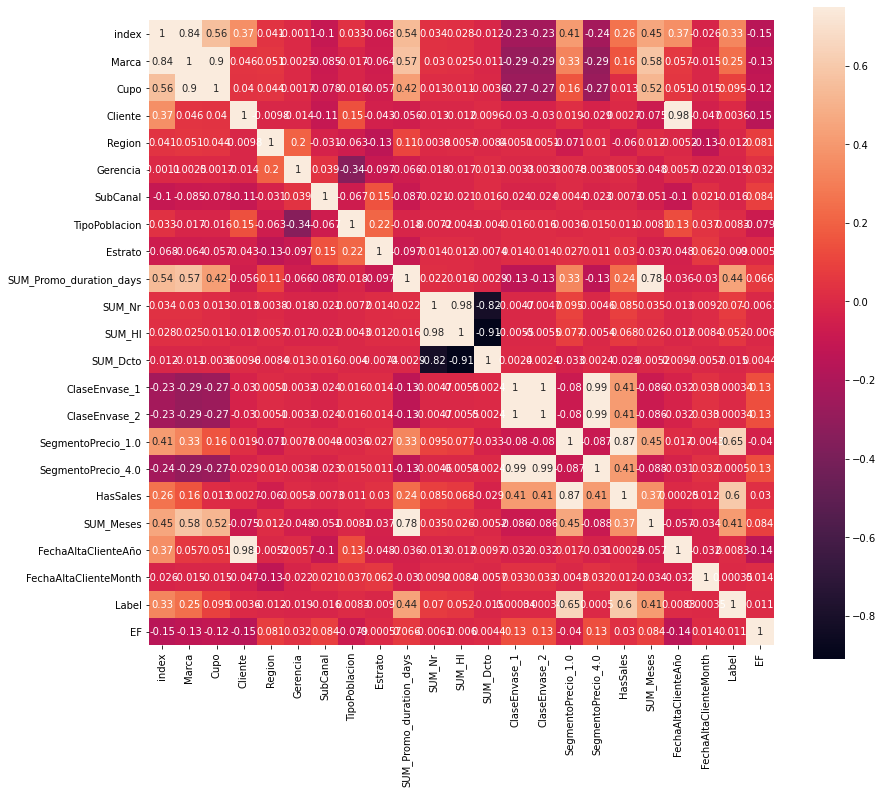

In [ ]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(df_train.corr(), vmax = 0.75, square = True, annot = True)

High correlation between:

* SUM_Hl <> Sum_Nr : 0.98
* SUM_Dcto <> Sum_Nr: -0.82
* SUM_Dcto <> Sum_Hl: -0.91
* ClaseEnvase_1 <> ClaseEnvase_2: 1
* ClaseEnvase_1 <> SegmentoPrecio_4.0: 0.99
* ClaseEnvase_2 <> SegmentoPrecio_4.0: 0.99
* Cliente <> FechaAltaClienteAño: 0.98
* Cupo <> Marca: 0.9 

Strong correlations between two other features would suggest that only one of them is necessary for our model (and including the other would in fact induce noise and potentially lead to over-fitting).

In [ ]:
executed = df_train[df_train['Label']==1]
not_executed = df_train[df_train['Label']==0]

executed_col = "blue"
not_executed_col = "red"

Median age survivors: 56387.7, Median age non-survivers: 0.0


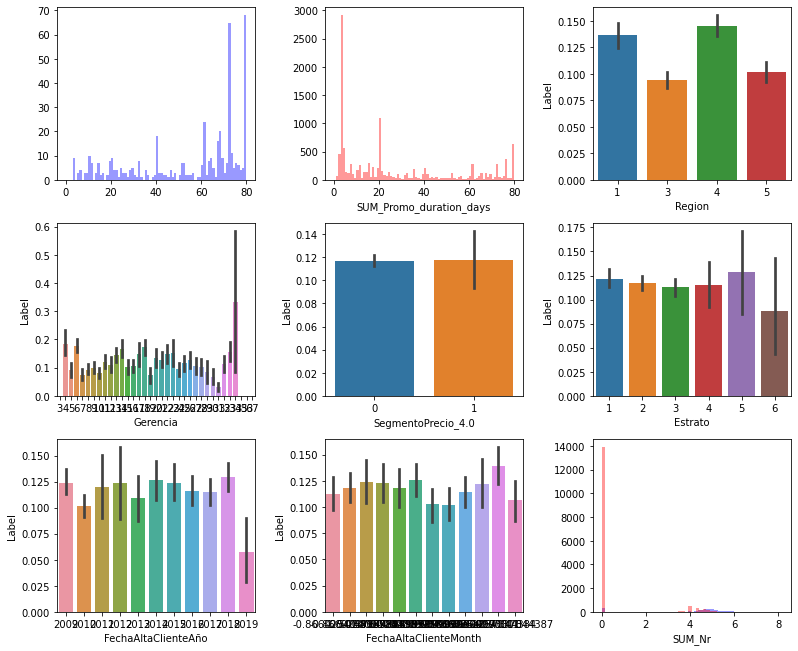

In [ ]:
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(executed['SUM_Promo_duration_days'].dropna().values, bins=range(0, 81, 1), kde=False, color=executed_col)
plt.subplot(332)
sns.distplot(not_executed['SUM_Promo_duration_days'].dropna().values, bins=range(0, 81, 1), kde=False, color=not_executed_col,
            axlabel='SUM_Promo_duration_days')
plt.subplot(333)
sns.barplot('Region', 'Label', data=df_train)
plt.subplot(334)
sns.barplot('Gerencia', 'Label', data=df_train)
plt.subplot(335)
sns.barplot('SegmentoPrecio_4.0', 'Label', data=df_train)
plt.subplot(336)
sns.barplot('Estrato', 'Label', data=df_train)
plt.subplot(337)
sns.barplot('FechaAltaClienteAño', 'Label', data=df_train)
plt.subplot(338)
sns.barplot('FechaAltaClienteMonth', 'Label', data=df_train)
plt.subplot(339)
sns.distplot(np.log10(executed['SUM_Nr'].dropna().values+1), kde=False, color=executed_col)
sns.distplot(np.log10(not_executed['SUM_Nr'].dropna().values+1), kde=False, color=not_executed_col,axlabel='SUM_Nr')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(executed['SUM_Nr'].dropna()), np.median(not_executed['SUM_Nr'].dropna())))

Median age survivors: 56387.7, Median age non-survivers: 0.0


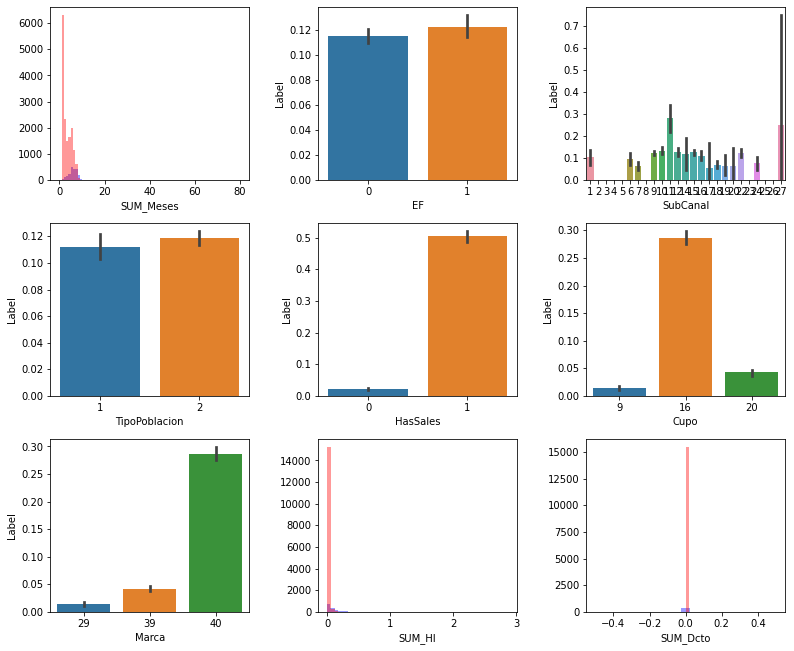

In [ ]:
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(executed['SUM_Meses'].dropna().values, bins=range(0, 81, 1), kde=False, color=executed_col)
sns.distplot(not_executed['SUM_Meses'].dropna().values, bins=range(0, 81, 1), kde=False, color=not_executed_col,
            axlabel='SUM_Meses')
plt.subplot(332)
sns.barplot('EF', 'Label', data=df_train)
plt.subplot(333)
sns.barplot('SubCanal', 'Label', data=df_train)
plt.subplot(334)
sns.barplot('TipoPoblacion', 'Label', data=df_train)
plt.subplot(335)
sns.barplot('HasSales', 'Label', data=df_train)
plt.subplot(336)
sns.barplot('Cupo', 'Label', data=df_train)
plt.subplot(337)
sns.barplot('Marca', 'Label', data=df_train)
plt.subplot(338)
sns.distplot(np.log10(executed['SUM_Hl'].dropna().values+1), kde=False, color=executed_col)
sns.distplot(np.log10(not_executed['SUM_Hl'].dropna().values+1), kde=False, color=not_executed_col,axlabel='SUM_Hl')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(339)
sns.distplot(np.log10(executed['SUM_Dcto'].dropna().values+1), kde=False, color=executed_col)
sns.distplot(np.log10(not_executed['SUM_Dcto'].dropna().values+1), kde=False, color=not_executed_col,axlabel='SUM_Dcto')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(executed['SUM_Nr'].dropna()), np.median(not_executed['SUM_Nr'].dropna())))

Se ve la relación entre SUM_Meses que consiste en la cantidad de meses en los que se vendió el producto y se aplica Dcto de ser el caso con la etiqueta promoción ejecutada, asimismo se ve la relación entre HasSales y esta.

In [ ]:
df_train["SUM_Dcto"].min()

-47458195.6

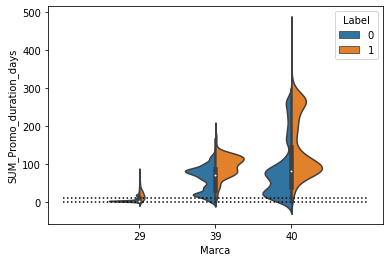

In [ ]:
sns.violinplot(x="Marca", y="SUM_Promo_duration_days", hue="Label", data=df_train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

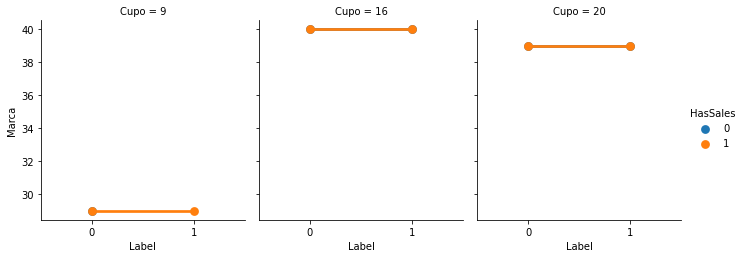

In [ ]:
g = sns.factorplot(x="Label", y="Marca", hue="HasSales", col="Cupo",
                   data=df_train, aspect=0.9, size=3.5, ci=95.0)

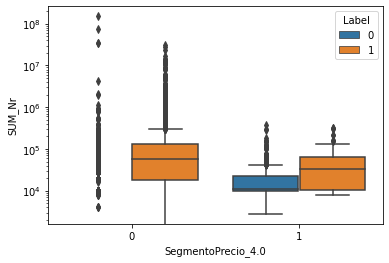

In [ ]:
ax = sns.boxplot(x="SegmentoPrecio_4.0", y="SUM_Nr", hue="Label", data=df_train);
ax.set_yscale('log')

In [ ]:
np.log10(-1*df_train['SUM_Dcto']+1)

2        0.0
4        0.0
5        0.0
9        0.0
16       0.0
        ... 
34542    0.0
34543    0.0
34546    0.0
34548    0.0
34550    0.0
Name: SUM_Dcto, Length: 17681, dtype: float64

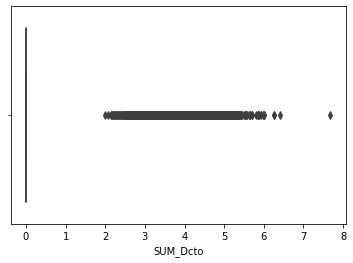

In [ ]:
sns.boxplot(x=np.log10(-1*df_train['SUM_Dcto']+1))

#### FILTERING OUTLIERS

In [ ]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df_train))
print(z)

[[1.58399426 1.42906722 1.33589124 ... 0.79592021 0.3643404  1.50907051]
 [1.5838011  1.42906722 1.33589124 ... 0.79592021 0.3643404  0.66265956]
 [1.58370452 1.42906722 1.33589124 ... 0.79592021 0.3643404  1.50907051]
 ...
 [1.75227804 0.79388941 0.21559937 ... 0.79592021 0.3643404  0.66265956]
 [1.7524712  0.79388941 0.21559937 ... 0.79592021 0.3643404  1.50907051]
 [1.75266436 0.79388941 0.21559937 ... 0.79592021 0.3643404  0.66265956]]


In [ ]:
threshold = 3
print(np.where(z > 3))

(array([    1,     1,     1, ..., 17497, 17563, 17614]), array([13, 14, 16, ...,  8,  8,  8]))


In [ ]:
df_train.shape

(17681, 23)

In [ ]:
df_train_o = df_train[(z < 3).all(axis=1)]

In [ ]:
df_train_o.shape

(16052, 23)

In [ ]:
df_train_o[df_train_o['SUM_Dcto']==0].shape

(14630, 23)

In [ ]:
df_train_o[df_train_o['SUM_Nr']==0].shape

(13615, 23)

In [ ]:
df_train_o[df_train_o['SUM_Hl']==0].shape

(13615, 23)

FEATURES FINALES

In [ ]:
features = df_train_o[['Marca','Cupo','Region', 'Gerencia', 'SubCanal',
       'TipoPoblacion', 'Estrato', 'SUM_Promo_duration_days', 'SUM_Nr', 
       'SUM_Hl','SUM_Dcto', 'SegmentoPrecio_1.0', 'SUM_Meses', 'FechaAltaClienteMonth', 'EF','HasSales']]

target = df_train_o[['Label']]

## MODELING

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit 

splitter=StratifiedShuffleSplit(n_splits=2,random_state=7, test_size=0.3) 

for train,test in splitter.split(features,target):     #this will splits the index
    X_train = features.iloc[train]
    y_train = target.iloc[train]
    X_test = features.iloc[test]
    y_test = target.iloc[test]

In [ ]:
y_train['Label'].value_counts()

0    10131
1     1105
Name: Label, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy={0:11000, 1:3300}, random_state=10)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [ ]:
temporal_df = pd.DataFrame(y_smote)
temporal_df.value_counts()

0    11000
1     3300
dtype: int64

In [ ]:
from xgboost import XGBClassifier
xgbr=XGBClassifier(n_estimators=1500,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.5,
    random_state=12,
    n_jobs=-1,)

In [ ]:
xgbr.fit(X_smote, y_smote)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, gamma=0.4,
              learning_rate=0.002, max_delta_step=0, max_depth=2,
              min_child_weight=0.1, missing=None, n_estimators=1500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=12,
              reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.47, verbosity=1)

In [ ]:
y_pred = xgbr.predict(X_test.values)

In [ ]:
print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9863    0.9959    0.9911      4342
           1     0.9583    0.8734    0.9139       474

    accuracy                         0.9838      4816
   macro avg     0.9723    0.9346    0.9525      4816
weighted avg     0.9836    0.9838    0.9835      4816



In [ ]:
y_test['Label'].value_counts()

0    4342
1     474
Name: Label, dtype: int64

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.984\nPrecision=0.958\nRecall=0.873\nF1 Score=0.913907284768212')

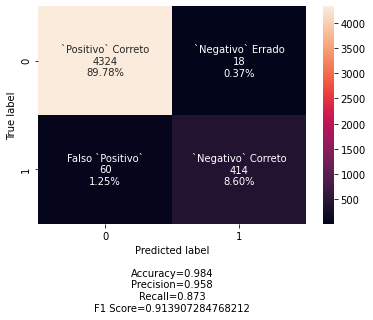

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

100%|██████████| 10/10 [01:26<00:00,  8.67s/it]


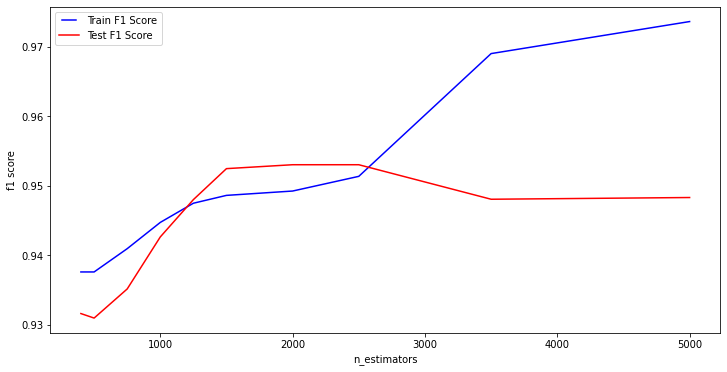

In [ ]:
from sklearn.metrics import f1_score

n_estimators = [400,500,750,1000,1250,1500,2000,2500,3500,5000]
train_pred_mse = []
test_pred_mse = []

for n_estimator in tqdm(n_estimators):
    xgbr=XGBClassifier(n_estimators=n_estimator,
      min_child_weight=0.1,
      learning_rate=0.002,
      max_depth=2,
      subsample=0.47,
      colsample_bytree=0.35,
      gamma=0.4,
      reg_lambda=0.4,
      random_state=7,
      n_jobs=-1,)
    xgbr.fit(X_smote, y_smote)

    y_train_pred = xgbr.predict(X_smote)
    y_test_pred = xgbr.predict(X_test.values)

    train_pred_mse.append(f1_score(y_smote, y_train_pred, average='macro'))
    test_pred_mse.append(f1_score(y_test, y_test_pred, average='macro'))
        
fig = plt.figure(figsize=[12,6])

line1, = plt.plot(n_estimators, train_pred_mse, 'b', label="Train F1 Score")
line2, = plt.plot(n_estimators, test_pred_mse, 'r', label="Test F1 Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('f1 score')
plt.xlabel('n_estimators')
plt.show()

100%|██████████| 6/6 [01:41<00:00, 16.88s/it]


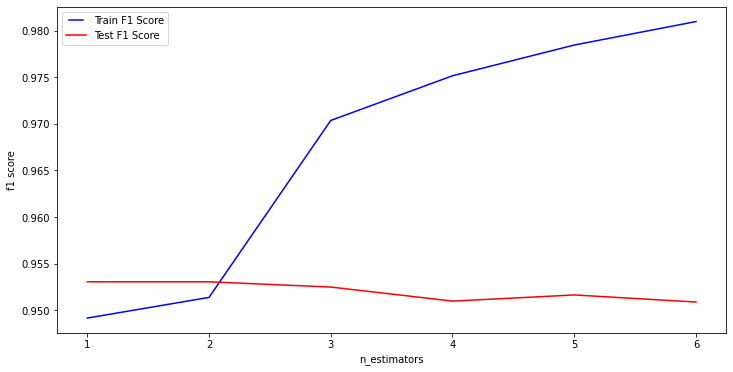

In [ ]:
from sklearn.metrics import f1_score

max_depths = [1,2,3,4,5,6]
train_pred_mse = []
test_pred_mse = []

for max_d in tqdm(max_depths):
    xgbr=XGBClassifier(n_estimators=2500,
      min_child_weight=0.1,
      learning_rate=0.002,
      max_depth=max_d,
      subsample=0.47,
      colsample_bytree=0.35,
      gamma=0.4,
      reg_lambda=0.4,
      random_state=7,
      n_jobs=-1,)
    xgbr.fit(X_smote, y_smote)

    y_train_pred = xgbr.predict(X_smote)
    y_test_pred = xgbr.predict(X_test.values)

    train_pred_mse.append(f1_score(y_smote, y_train_pred, average='macro'))
    test_pred_mse.append(f1_score(y_test, y_test_pred, average='macro'))
        
fig = plt.figure(figsize=[12,6])

line1, = plt.plot(max_depths, train_pred_mse, 'b', label="Train F1 Score")
line2, = plt.plot(max_depths, test_pred_mse, 'r', label="Test F1 Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('f1 score')
plt.xlabel('max_depth')
plt.show()

### K NEAREST NEIGHBOURS

In [ ]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X_smote,y_smote)
y_pred = clf_knn.predict(X_test)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.963\nPrecision=0.820\nRecall=0.872\nF1 Score=0.8454332552693208')

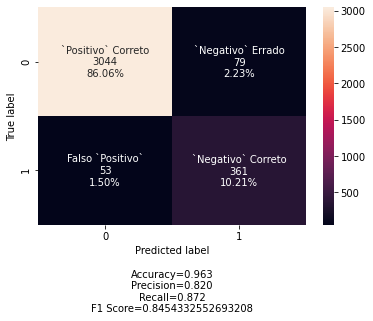

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### Decision Trees


In [ ]:
clf_dtc = DecisionTreeClassifier(max_depth=15).fit(X_smote, y_smote)
y_pred = clf_dtc.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.965\nPrecision=0.868\nRecall=0.829\nF1 Score=0.8479604449938196')

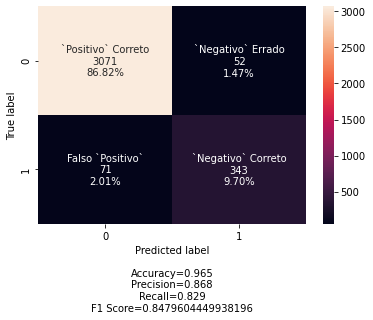

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### RANDOM FOREST

In [ ]:
clf_rf = RandomForestClassifier(
    n_estimators=1500, \
    max_depth=2, \
    min_samples_split=10,
    min_samples_leaf = 1 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X_smote,y_smote)
y_pred = clf_rf.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.984\nPrecision=0.969\nRecall=0.867\nF1 Score=0.9153674832962138')

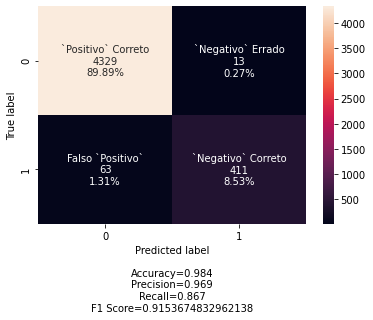

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

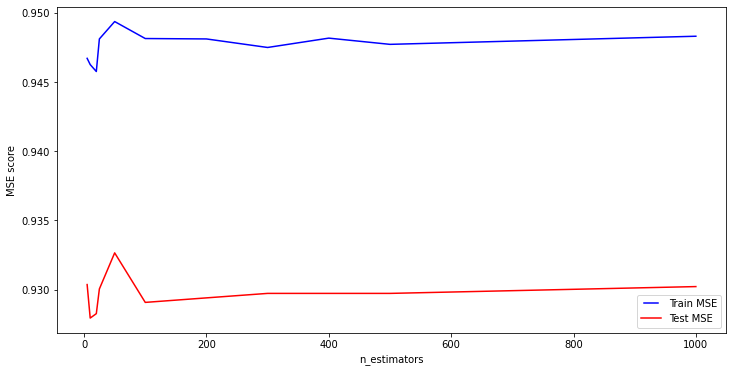

In [ ]:
n_estimators = [5, 10, 20, 25, 50, 100, 200,300,400,500,1000]
train_pred_mse = []
test_pred_mse = []

for n_estimator in n_estimators:
    model = RandomForestClassifier(
        n_estimators = n_estimator,
        min_samples_leaf = 1,
        max_depth = 8
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test.values)

    train_pred_mse.append(f1_score(y_train, y_train_pred, average='macro'))
    test_pred_mse.append(f1_score(y_test, y_test_pred, average='macro'))
        
fig = plt.figure(figsize=[12,6])

line1, = plt.plot(n_estimators, train_pred_mse, 'b', label="Train MSE")
line2, = plt.plot(n_estimators, test_pred_mse, 'r', label="Test MSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
clf_rf = RandomForestClassifier(
    n_estimators=25, \
    max_depth = 8, \
    min_samples_leaf = 1,
    min_samples_split=10,
    random_state=7 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X_smote,y_smote)
y_pred = clf_rf.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.970\nPrecision=0.893\nRecall=0.842\nF1 Score=0.8668320926385443')

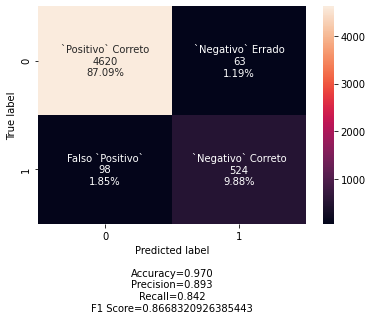

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### EXTREMELY RANDOMIZED TREE

In [ ]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X_smote,y_smote)
y_pred = clf_ext.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.951\nPrecision=0.773\nRecall=0.825\nF1 Score=0.7978227060653188')

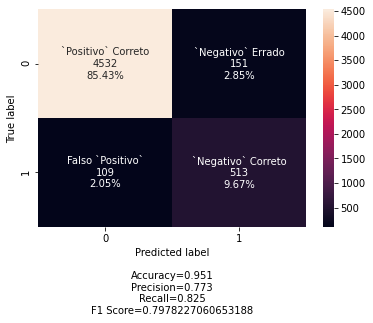

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### GRADIENT BOOSTING

In [ ]:
clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1500,
            learning_rate=0.1,
            max_depth=2,
            subsample=0.3,
            random_state=7)
clf_gb.fit(X_smote,y_smote)
y_pred = clf_gb.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.979\nPrecision=0.901\nRecall=0.884\nF1 Score=0.8924387646432376')

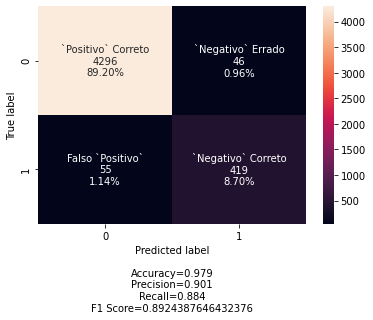

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### LIGHTGBM

In [ ]:
import lightgbm as lgb
clf_lgb = lgb.LGBMClassifier(
    max_depth=2,
    n_estimators=1500,
    subsample=0.5,
    learning_rate=0.05
    )
clf_lgb.fit(X_smote,y_smote)
y_pred = clf_lgb.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.981\nPrecision=0.928\nRecall=0.873\nF1 Score=0.9')

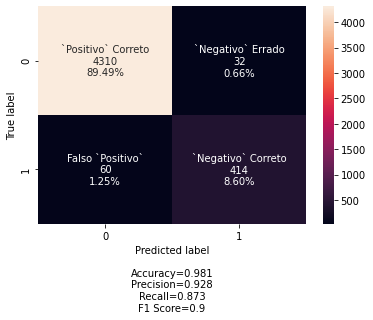

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### STACKING / ENSEMBLE

Se utilizaran los modelos con mayor resultado (GF, XGB, RF, LGB, KNN)

In [ ]:
clf_vote = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('xgb', xgbr),
        ('rf', clf_rf),
        ('lgb', clf_lgb),
        ('knn',clf_knn)
        ],
    weights=[1,4,1,1,2],
    voting='soft')
clf_vote.fit(X_smote,y_smote)

y_pred = clf_vote.predict(X_test.values)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.982\nPrecision=0.931\nRecall=0.880\nF1 Score=0.9045553145336225')

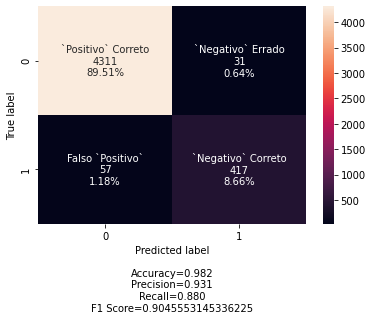

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [ ]:
roc_auc_score(y_test, y_pred)

0.9363036342116158

### SUBMISSION

Seleccionando los features considerados en el entrenamiento

In [ ]:
df_test_sub = df_test[['Marca','Cupo','Region', 'Gerencia', 'SubCanal',
       'TipoPoblacion', 'Estrato', 'SUM_Promo_duration_days', 'SUM_Nr', 
       'SUM_Hl','SUM_Dcto', 'SegmentoPrecio_1.0', 'SUM_Meses', 'FechaAltaClienteMonth', 'EF','HasSales']]

In [ ]:
df_test_sub.head()

,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,SegmentoPrecio_1.0,SUM_Meses,FechaAltaClienteMonth,EF,HasSales
0,40,16,4,21,15,2,2,312.0,31294.09,0.15,-16616.07,1,10,0.5,0,1
1,29,9,4,21,15,2,5,30.0,194819.19,0.28,-4855.17,0,4,0.5,1,1
2,29,9,4,21,16,2,3,25.0,0.00,0.00,0.00,0,2,0.5,1,0
3,29,9,4,21,9,2,3,39.0,76860.67,0.11,-784.85,0,4,0.5,1,1
4,29,9,4,21,10,2,2,31.0,0.00,0.00,0.00,0,2,0.5,0,0


In [ ]:
df_test_sub.nunique()

Marca                         3
Cupo                          3
Region                        5
Gerencia                     33
SubCanal                     24
TipoPoblacion                 2
Estrato                       6
SUM_Promo_duration_days     337
SUM_Nr                     7346
SUM_Hl                     1964
SUM_Dcto                   5420
SegmentoPrecio_1.0            2
SUM_Meses                    13
FechaAltaClienteMonth        12
EF                            2
HasSales                      2
dtype: int64

In [ ]:
y_prob_sub = clf_vote.predict_proba(df_test_sub.values)

In [ ]:
y_prob_sub

array([[0.09117555, 0.90882445],
       [0.1527175 , 0.8472825 ],
       [0.98025438, 0.01974562],
       ...,
       [0.04559571, 0.95440429],
       [0.98209121, 0.0179088 ],
       [0.1569983 , 0.8430017 ]])

In [ ]:
y_sub = clf_vote.predict(df_test_sub.values)

In [ ]:
y_sub

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
(unique, counts) = np.unique(y_sub, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    0 10094]
 [    1  6776]]


In [ ]:
df_test_sub["Ejecuto_Promo"] = y_prob_sub[:,1]
df_test_sub["Cliente"] = df_test["Cliente"]
df_test_sub["Marca"] = df_test["Marca"]
df_test_sub["Cupo"] = df_test["Cupo"]

In [ ]:
df_test_sub.tail()

,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,SUM_Promo_duration_days,SUM_Nr,SUM_Hl,SUM_Dcto,SegmentoPrecio_1.0,SUM_Meses,FechaAltaClienteMonth,EF,HasSales,Ejecuto_Promo,Cliente
16865,40,16,3,10,15,2,3,23.0,47825.42,0.15,0.00,1,2,0.5,0,1,0.186505,15053
16866,40,16,5,27,9,2,1,42.0,142311.22,0.45,-1171.00,1,3,0.5,0,1,0.881129,15054
16867,40,16,4,26,15,2,2,206.0,73643.49,0.27,-12506.04,1,4,0.5,0,1,0.954404,15056
16868,29,9,1,16,9,2,2,51.0,0.00,0.00,0.00,0,4,0.5,1,0,0.017909,15057
16869,29,9,1,18,1,2,4,40.0,45802.95,0.07,-4130.52,0,3,0.5,0,1,0.843002,15064


In [ ]:
df_test_submission = df_test_sub[["Cliente","Marca","Cupo","Ejecuto_Promo"]]

In [ ]:
df_test_submission.head()

,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.908824
1,17,29,9,0.847282
2,37,29,9,0.019746
3,46,29,9,0.731662
4,48,29,9,0.020205


In [ ]:
df_test_submission.shape

(16870, 4)

In [ ]:
df_test_submission.to_csv('result_vote_no_out.csv', index=False)

## CONCLUSIONES

* La elección y creación de la etiqueta requiere una revisión y mejora.
* Se esta introduciendo ruido en la data al aplicar los SUM de las ventas, meses, duración en días de la promoción.
* Aplicar un mejor balanceo de datos.